<a href="https://colab.research.google.com/github/ekalmes/Portfolio/blob/main/LogisticRegressionAsNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Zeke Kalmes

Collaborator: Emily Heim

Date: 02/04/2021

# Logistic Regression as a Neural Network

Our basic goal here is to implement logistic regression as a neural network as presented by Andrew Ng.  This will help us become more comfortable with coding with Python, Jupyter, NumPy and related tools.  Implementing the computations ourselves will help us better understand the process of training a neural network as well.

In this notebook, we will implement logistic regression and use it to train a model that attempts to classify images of sign-language digits (0 through 9).  This is a basic computer vision task known as "image classification."

## Assignment Instructions
1. Create a text cell as the first cell in the notebook (above the title) including your name, the date, and the name of whoever you worked on the in-class exercise with.
1. Read everything *carefully*!  Don't skim anything.  You don't want to miss an important detail.
1. Set the `DIGIT` variable to your assigned digit in the existing cell where `DIGIT` is set below.
1. Implement and test each of the functions under **Functions**.
1. Use your functions to train a good model for your assigned digit-classification problem.  
1. Record the best cost function achieved for your model (in 30 iterations) in the linked spreadsheet.
1. Write up some analysis following the given prompts in that section.

Also:
* Ask questions.  Piazza is best for questions about the assignment itself (clarifications, suggestions for how to start or approach something, etc.), while Discord or email is good for questions about your particular code.
* See the assignment on Moodle for submission instructions.

# Setup

## Imports

In [ ]:
# NumPy for all the matrix-y goodness
import numpy as np
# One function from scikit-learn (a full suite of machine learning code)
# for easily splitting test and training sets from a dataset.
from sklearn.model_selection import train_test_split
# Matplotlib for visualizing data and displaying images
import matplotlib.pyplot as plt
# A function to help update a single plot in place
from IPython.display import clear_output
# To let us limit chart updates based on time
import time

## Fetch and load the data

The data used here is a set of images of sign language digits.  It was created by students at Ayrancı Anadolu High School in Ankara, Turkey.  Source: https://github.com/ardamavi/Sign-Language-Digits-Dataset

In [ ]:
# Fetch data
! [ -e sign_digits_X.npy ] && echo "sign_digits_X.npy exists" || wget https://sun.iwu.edu/~mliffito/class_data/sign_digits_X.npy
! [ -e sign_digits_Y.npy ] && echo "sign_digits_Y.npy exists" || wget https://sun.iwu.edu/~mliffito/class_data/sign_digits_Y.npy

--2021-02-04 15:49:52--  https://sun.iwu.edu/~mliffito/class_data/sign_digits_X.npy
Resolving sun.iwu.edu (sun.iwu.edu)... 198.178.132.10
Connecting to sun.iwu.edu (sun.iwu.edu)|198.178.132.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33783936 (32M) [text/plain]
Saving to: ‘sign_digits_X.npy’

sign_digits_X.npy   100%[===================>]  32.22M  3.83MB/s    in 8.5s    

2021-02-04 15:50:00 (3.78 MB/s) - ‘sign_digits_X.npy’ saved [33783936/33783936]

--2021-02-04 15:50:00--  https://sun.iwu.edu/~mliffito/class_data/sign_digits_Y.npy
Resolving sun.iwu.edu (sun.iwu.edu)... 198.178.132.10
Connecting to sun.iwu.edu (sun.iwu.edu)|198.178.132.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82608 (81K) [text/plain]
Saving to: ‘sign_digits_Y.npy’

sign_digits_Y.npy   100%[===================>]  80.67K  --.-KB/s    in 0.1s    

2021-02-04 15:50:01 (826 KB/s) - ‘sign_digits_Y.npy’ saved [82608/82608]



In [ ]:
# Load data
X = np.load("sign_digits_X.npy")
Y = np.load("sign_digits_Y.npy")

In [ ]:
# Always look at the shape of the data to situate yourself and check for errors.
print(f"X.shape: {X.shape}")
print(f"Y.shape: {Y.shape}")

X.shape: (2062, 64, 64)
Y.shape: (2062, 10)


In [ ]:
# Helper function for displaying an example as an image
def show_example(X, index):
    plt.axis('off')
    plt.imshow(X[index], cmap='Greys')

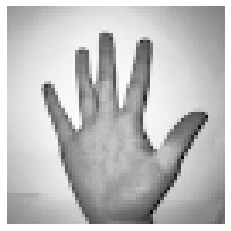

In [ ]:
# Check an individual example (change index to any valid index)
index = 1100
show_example(X, index)

## Set the digit this notebook will try to classify

The data set contains images of the digits 0 through 9 (10 labels in all).  Because logistic regression is for a binary classification, we will attempt to classify the images into the binary classification "Is [some digit]" vs "Is not [that digit]".

You should have been assigned a digit by the professor.  Set that here in the `DIGIT` variable to be used throughout the notebook.  (You can explore what happens with digits other than your assigned digit, but make sure you turn in your work with your assigned digit.)

In [ ]:
DIGIT = 2

assert 0 <= DIGIT <= 9

# Prepare Data

With the data fetched and the notebook setup, we can prepare our data.  Data is rarely available in exactly the format you need to pass to your model.  Here, it has already been cleaned up and packaged a lot, but even so we need to do some preparation before we can use it.

In [ ]:
# Convert one-hot encoding into a True/False (1.0 / 0.0) for "is a [DIGIT]" or not.
Y_is_DIGIT = Y[:, DIGIT]

In [ ]:
# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_is_DIGIT, test_size=0.2, random_state=42)

In [ ]:
# Check sizes of the split data
print(f"X_train.shape: {X_train.shape}  X_test.shape: {X_test.shape}")
print(f"Y_train.shape: {Y_train.shape}  Y_test.shape: {Y_test.shape}")

X_train.shape: (1649, 64, 64)  X_test.shape: (413, 64, 64)
Y_train.shape: (1649,)  Y_test.shape: (413,)


Now that we have our data prepared, we should look at it to make sure it's correct.

I cannot stress this enough: **always do this**.  **ALWAYS**.

Always look at your inputs, your intermediate results, your model's output...  Checking your data in this way helps you avoid major issues *and* helps you understand everything so much better.

1.0


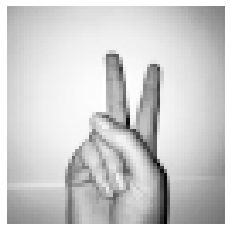

In [ ]:
# Check an individual example in the training data (verify we didn't break something)
index = 1100
show_example(X_train, index)
print(Y_train[index])

The way we have seen logistic regression implemented, our examples are expected to be stored in a matrix as columns.  Currently, they are more akin to rows, and each example is a two-dimensional vector itself.  We'll flatten and transpose the data here to get it in the desired form.

We also keep around the original data for easy visualization (because Matplotlib is happier when we give it an image as a 2D matrix rather than as a 1D flattened vector).

In [ ]:
# Flatten X examples into vectors and transpose so examples are in columns
X_train_flat = X_train.reshape((X_train.shape[0], -1)).T
X_test_flat = X_test.reshape((X_test.shape[0], -1)).T

print(f"X_train_flat.shape: {X_train_flat.shape}  X_test_flat.shape: {X_test_flat.shape}")

X_train_flat.shape: (4096, 1649)  X_test_flat.shape: (4096, 413)


# Functions

## Sigmoid

The sigmoid function is our "activiation function" for logistic regression.

Define `sigmoid(z)`:
 * Parameters:
   * `z`: a scalar, vector, or matrix
 * Return value:
   * The sigmoid of the scalar argument or a vector or matrix containing the sigmoid of all values in the parameter if it is a vector or matrix.

Sigmoid definition:
$$
    \sigma(x) = \frac{1}{1 + e^{-x}}
$$

Tips:
 * NumPy will automatically vectorize most operations.  That is, many NumPy functions will work correctly whether given a scalar, vector, or matrix.
 * $e^x$ is a very common operation -- so common that NumPy provides a function to compute it: [`numpy.exp()`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html).

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Always test your functions.  Test your code as much as possible.  Make sure it is correct before moving on.

In the code cell below, test your function for a few different scalar values.  A good test will test some extreme values, any well-known, well-defined points (`sigmoid(0)` is one such point in this case), and maybe a random value or two.  Find a way to verify your values are correct, and add a note with a comment in the cell explaining how you did that (with a URL if you used an online resource).

In [ ]:
# Test sigmoid(z) on several scalar values here.
# Same examples as Emily Heim, collaborator
print(sigmoid(0))
print(sigmoid(4))
print(sigmoid(-85))
print(sigmoid(.1))

0.5
0.9820137900379085
1.2160992992528256e-37
0.52497918747894


You can verify that your function works correctly on vectors using the following cell.  It will plot your function for values between -10 and 10.  It should match the curve of the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).  This also demonstrates how your function can automatically use vectorization: it passes your function an array of values and (if the function is correct) gets back an array of values.

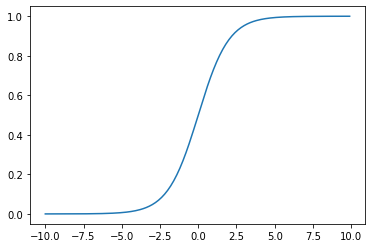

In [ ]:
# Generate x values
xrange = np.arange(-10,10,0.1)
# Plot x values vs the sigmoid of those same values
# See how sigmoid() is called with an array as its argument here?
plt.plot(xrange, sigmoid(xrange))

Finally, verify that it works when given a matrix by creating a simple, small (but at least 2x2) matrix and passing it to your `sigmoid()` function in the code cell below.

In [ ]:
# Test sigmoid(z) on a matrix here.
# initiated array with same values as above to test consistency
test_array = np.array([[0, 4], [-85, .1]])
print(sigmoid(test_array))

[[5.00000000e-01 9.82013790e-01]
 [1.21609930e-37 5.24979187e-01]]


Great! The values are consistent with the ones tested above. Interesting how the outputs for the array are all printed in scientific notation. 

## Initialize Parameters

It's helpful to initialize all of our model parameters in a function, just to help with organization.

Define `init_params(size)`:
 * Parameters:
   * `size`: $n_x$, the number of values in a single example vector
 * Return values:
   * `w`: A vector for $w$
   * `b`: A scalar for $b$
   * All values should be initialized to 0

Tips:
 * See [`numpy.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html) for initializing an array of all zeros.

In [ ]:
def init_params(size):
    w = np.zeros((size,1))
    b = 0
    return w, b

This one is fairly simple, but it still should be tested.  Write some code to verify it works correctly in the cell below.

In [ ]:
# Test init_params() here
w,b = init_params(10)
print(w.shape)
print(w[0])
print(b)

(10, 1)
[0.]
0


Great! The shape of the array is a column vector of shape (10,1), it was initialized with 0.0's (floats, as type was not specified), and b was initialized to 0 as well. 

## Forward Propagation

Forward propagation is used in training and in evaluating any new example against the model.

Define `forward_propagate(w, b, X)`:
 * Parameters:
   * `w`: The set of weights $w$ for our model
   * `b`: The bias/offset value $b$ for our model
   * `X`: One example (as a vector) or a set of examples (as a matrix with each example in a *column*)
 * Return value:
   * `A`: The prediction (aka $\hat{y}$ or $\hat{Y}$) produced for `X` by the given model (`w` and `b`).
     * If `X` is a vector, `A` should be a scalar (the prediction for that one example)
     * If `X` is a matrix, `A` should be a vector with one prediction for each example in `X`

Tips:
 * Again, NumPy will automatically vectorize most operations.  In this case, the same code can work correctly whether `X` is a matrix or a vector.
 * Given that you will be performing either the dot product or matrix multiplication depending on whether `X` is a vector or a matrix, use `np.dot()`, which will automatically perform the correct operation depending on the shape of the operands.  It appears to be the convention to use `np.dot()` in these cases (as opposed to `np.matmul()`).

In [ ]:
 def forward_propagate(w, b, X):
    A = sigmoid(np.dot(w.T, X) + b)
    return A

Above, np.dot() takes the dot product or performs matrix multiplication between the transposed vector of weights, w, and the sample X, which is either a vector or an array. The cross product is then offset by the bias, b, which gets broadcasted over all values in the resulting (1,m) array. This results in Z, which doesn't need to be explicitly defined, completing the pre-activation step. Z is then passed into the sigmoid function created earlier, resulting in a (1,m) row array of activated values. 

Write code to test your `forward_propagate()` function and verify its correctness below.

In [ ]:
# Test forward_propagate() here.
test_X = np.random.randn(10,1)
print("test_X shape: ", test_X.shape)
A1 = forward_propagate(w, b, test_X)
print(A1.shape)
print(A1[0])

test_X shape:  (10, 1)
(1, 1)
[0.5]


With w being implemented earlier as a vector populated with 10 0's, the test_X vector needed to have 10 elements as well. With the bias, b, being 0 as well, all of the values in Z should be 0 (0*0+0=0); so, when they are passed into the sigmoid activation function, all values in the result, A, should be 0.5. Next, test_X1 will be implemented as a (10,3) array to test the matrix multiplication capabilities. 

In [ ]:
# Test forward_propagate() here.
test_X1 = np.zeros((10,3))
print("test_X1 shape: ", test_X1.shape)
A2 = forward_propagate(w, b, test_X1)
print("A2 shape: ", A2.shape)
print("A2[0]: ", A2[0])
print("A2[0][0]: ", A2[0][0])

test_X1 shape:  (10, 3)
A2 shape:  (1, 3)
A2[0]:  [0.5 0.5 0.5]
A2[0][0]:  0.5


Good, everything looks correct, all the values in the array A of activated values are 0.5 and the shape of A is (1,m).

## Calculate the cost function

For any given model ($w$ and $b$) and set of labeled examples ($X$ and $Y$), we can compute the cost function $J(w, b)$.  This tells us the average *error* for the models predictions on those examples when compared to their labels.

Here, we assume we have already computed the predictions and compute the cost function given those predictions and the correct labels.

Define `calc_cost(A, Y)`:
 * Parameters:
   * `A`: Predictions for a set of examples (aka $\hat{Y}$).
   * `Y`: Correct labels for the same set of examples.
 * Return value:
   * `cost`: The value of the cost function for these predictions/labels.

For logistic regression, we are using the *loss* function:
$$
\mathcal{L}(a, y) = -(y \log(a) + (1-y)\log(1-a))
$$

And the *cost* function is the average of the loss function over all examples.

In [ ]:
def calc_cost(A, Y):
    size = A.shape[1]
    cost = -(1/size) * (np.sum((Y * np.log(A)) + (1-Y) * np.log(1-A)))
    return cost

This is a numerical function, and its tests should use some of the same ideas as testing `sigmoid()` above.  Test a range of inputs, including edge cases, well-defined points, and a few random ones.

In [ ]:
# Test calc_cost() here
#print(calc_cost(A, test_X))
test_Y = np.array([1,1,1])
test_cost = calc_cost(A2, test_Y)
print(test_cost)

0.6931471805599452


In [ ]:
test_A = np.array([0,0,0])
test_A = test_A.reshape(1,3)
print(test_A.shape)
test_Y = np.array([1,1,1])
test_Y = test_Y.reshape(1,3)
test_cost1 = calc_cost(test_A, test_Y)
print(test_cost1)

(1, 3)
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


This should produce an error, because the natural log of 0 is undefined. 

In [ ]:
test_A1 = np.random.rand(1,3)
test_Y1 = np.array([1,1,1])
test_Y1 = test_Y1.reshape(1,3)
test_cost2 = calc_cost(test_A1, test_Y1)
print(test_cost2)

0.4421977174355206


## Backpropagation *aka* "Backprop"

Backprop is used to update the model parameters ($w$ and $b$) given one or more labeled training examples.  It computes the partial derivatives of the cost function with respect to each of the model parameters.  These derivatives can then be used to update the model using gradient descent.

As Andrew Ng points out, technically all of the derivatives we are calculating in these processes are partial derivatives, but we will just refer to them as "derivatives" for brevity.

Define `backprop(X, A, Y)`:
 * Parameters:
   * `X`: One example (as a vector) or a set of examples (as a matrix with each example in a *column*)
   * `A`: Predictions for the same set of examples (aka $\hat{Y}$).
   * `Y`: Correct labels for the same set of examples.
 * Return values:
   * `dw`: The derivative of the cost function with respect to `w` for each parameter in `w`
     * That is, since `w` is a vector, `dw` is a vector where each element `dw[i]` is the derivative with respect to the matching value in `w`, `w[i]`.
   * `db`: The derivative of the cost function with respect to `b`

In [ ]:
# implemented using the equations for dw, db provided by Andrew Ng
def backprop(X, A, Y):
    dw = (1/X.shape[1]) * np.dot(X, ((A-Y).T))
    db = (1/X.shape[1]) * np.sum(A-Y)
    return dw, db

Test test test!

In [ ]:
# Test backprop() here
bp_test_X = np.ones((10,3))
bp_test_A = np.ones((1,3))
bp_test_Y = np.ones((1,3))
bp_test_dw, bp_test_db = backprop(bp_test_X, bp_test_A, bp_test_Y)
print(bp_test_dw.shape)
print(bp_test_db.shape)
print(bp_test_dw)


(10, 1)
()
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Good, this makes sense intuitively. Since A and Y should both be (1,3) arrays populated with 1's, the derivatives should be 0 as there is no change. 

## Update

After backprop, we can update the model by performing gradient descent with the computed derivatives.  This is controlled by the *learning rate* $\alpha$ ('alpha').

Define `update(w, b, dw, db, alpha)`:
 * Parameters:
   * `w`: The set of weights $w$ for our model
   * `b`: The bias/offset value $b$ for our model
   * `dw`: The derivative of the cost function with respect to `w` for each parameter in `w` (as computed in `backprop()`)
   * `db`: The derivative of the cost function with respect to `b` (as computed in `backprop()`)
   * `alpha`: The learning rate $\alpha$
 * Return values:
   * `new_w`: The updated weights
   * `new_b`: The updated bias/offset value

**Good coding practice**: Note that this does *not* update `w` and `b` itself.  It is poor practice to modify the arguments passed into a function, as this often leads to subtle, infuriating bugs.  Instead, in most cases we prefer to return modified versions that can be used to overwrite the arguments *outside* of the function, if desired.

In [ ]:
def update(w, b, dw, db, alpha):
    new_w = w - alpha * dw
    new_b = b - alpha * db
    return new_w, new_b

You know the drill.  For this one, testing a few different combinations of argument values makes sense.  A single test could provide a false sense of security if it misses some buggy behavior another test would catch.

In [ ]:
# Test update() here
u_test_w = np.random.randn(10,1)
print(u_test_w)
u_test_b = 0
u_test_dw = np.random.randn(10,1)
u_test_db = 1
u_test_alpha = 0.1
u_test_neww, u_test_newb = update(u_test_w, u_test_b, u_test_dw, u_test_db, u_test_alpha)
print(u_test_neww.shape)
print(u_test_neww)
print(u_test_newb)

[[ 1.05203103]
 [-0.38212803]
 [ 0.70536119]
 [-1.57402834]
 [-0.16723036]
 [ 0.11789781]
 [ 1.08228849]
 [-0.32240228]
 [ 1.0804315 ]
 [-0.65741623]]
(10, 1)
[[ 1.06653931]
 [-0.33420547]
 [ 0.69426902]
 [-1.45044785]
 [-0.18316783]
 [ 0.15324654]
 [ 1.01097372]
 [-0.27249711]
 [ 0.90788632]
 [-0.67939298]]
-0.1


As we can see, new w and new b are both updated by multiplying the dw/db by the alpha, and then subtracting these from the original w/b values. The -0.1 value for u_test_newb is an easy value to understand, as the calculation didn't start with a random float. 


In [ ]:
# Test update() here
u_test_w1 = np.random.randn(10,1)
print(u_test_w1)
u_test_b1 = 0.5
u_test_dw1 = np.random.randn(10,1)
u_test_db1 = 1
u_test_alpha1 = 0.01
u_test_neww1, u_test_newb1 = update(u_test_w1, u_test_b1, u_test_dw1, u_test_db1, u_test_alpha1)
print(u_test_neww1.shape)
print(u_test_neww1)
print(u_test_newb1)

[[ 0.59546325]
 [ 0.12537224]
 [ 1.02427523]
 [ 1.32272034]
 [-0.49902456]
 [ 0.30697855]
 [ 1.5219935 ]
 [-0.30300921]
 [ 0.66123874]
 [-1.20920198]]
(10, 1)
[[ 0.59527748]
 [ 0.11979044]
 [ 1.02964428]
 [ 1.33351648]
 [-0.48413274]
 [ 0.29470453]
 [ 1.51695294]
 [-0.28576958]
 [ 0.65941237]
 [-1.21575423]]
0.49


Teenie weenie alpha steps. Again, the outputted new b value gives a good view into whether or not the rest of it worked. 

## One training iteration

Training often occurs over multiple iterations of gradient descent.  It is very convenient to put a single iteration of this process in its own function.  We can then call it as many times as we want.

Define `train_iteration(w, b, X, Y, alpha)`:
 * Parameters:
   * `w`: The set of weights $w$ for our model
   * `b`: The bias/offset value $b$ for our model
   * `X`: One example (as a vector) or a set of examples (as a matrix with each example in a *column*)
   * `Y`: Correct labels for the same set of examples.
   * `alpha`: The learning rate $\alpha$   
 * Return values:
   * `new_w`: The updated weights
   * `new_b`: The updated bias/offset value
   * `cost`: The value of the cost function in this iteration
     * This should be computed *before* the update -- this is important to specify, because you *could* compute it after the update as well.  (Computing after the update would make sense, but it would add additional computations in this function that would be redundant and slow things down unnecessarily.)

In [ ]:
def train_iteration(w, b, X, Y, alpha):
    A = forward_propagate(w, b, X)
    cost = calc_cost(A, Y)
    dw, db = backprop(X, A, Y)
    new_w, new_b = update(w, b, dw, db, alpha)
    return new_w, new_b, cost

At this level, testing becomes harder, because it's harder for us to know what the "right answer" is.  However, if you have adequately tested the functions that make up this one, you will already have some confidence in it!  Still, test it to at least make sure the values it returns look *reasonable*, even if you can't easily verify them exactly.

In [ ]:
# Test train_iteration() here
Y_test = Y_test.reshape(1,413)
test_new_w, test_new_b, test_ti_cost = train_iteration(w,b,X_test_flat,Y_test, u_test_alpha)
print(test_new_w.shape)
print(test_new_w)
print(test_new_b)

(4096, 1)
[[-0.00192602]
 [-0.0018516 ]
 [-0.00175105]
 ...
 [-0.0024103 ]
 [-0.00263519]
 [-0.00269333]]
-0.005404689897602115


Good! The shape of the new_w column vector is correct, and the values all look relatively reasonable. 

# Training

If all of the above functions are implemented correctly, then we're ready to train a model!

Remember the overall goal of training: find a "good" set of weights for our model so that the model makes "good" predictions of the real example labels.

When training a model, we often need to explore different values for things like the learning rate to find which lead to the most efficient and effective training.  This exploration is called "hyperparameter search," and we'll learn more about it soon.  Here, though, you will so a little of that exploration just for the learning rate.

One tool we often use for this is to plot the model's performance over the iterations of training.  The code below has been set up to do that.  See the few places with `#TODO#` markers to see where to write your own code.  Only change those.

Using this cell, find a learning rate ($\alpha$ *aka* `alpha`) that leads to the best final training cost for your assigned digit after 30 iterations of training.

As you explore, write down the learning rates you use, the cost achieved in 30 iterations with each learning rate, and a few notes on what the cost curve looked like for each training.  See the prompts under **Analysis** for an idea of what to be looking at and recording.

**Best Cost Values:** At any point if you think you have a decent final cost value, please record it with your name under your assigned digit in [this spreadsheet](https://docs.google.com/spreadsheets/d/1zMeyeNyl_5k_FCsqVZgtIbSFn_iBeux-3rdr2B4yzYY/).  If you achieve a better cost function later, please go back and update your entry in the spreadsheet.  With this, we will be able to see how effective all of your models are at learning to classify each individual digit.

**Tips:**
* If you have no idea where to start with the learning rate, 1 is a good "neutral" number.
* To explore different learning rates, start by moving by multiples of 10.  For example, to move "up" from 1, try 10 as opposed to 2, 1.5, or a small jump.  This will let you more quickly explore a wide range of values.  You can always make smaller steps once you feel you're "close."
* Pay attention to what the plotted curve is telling you.  What would it look like in a perfect situation where the training happens perfectly right away?  In general, should it be going up or down?  What does it mean if it is fairly flat?  What does it mean if it is oscillating up and down?

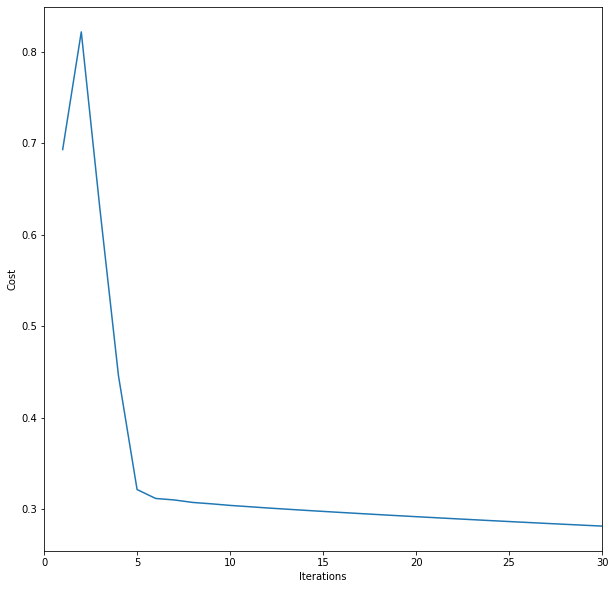

Final training cost: 0.28157452741997724


In [ ]:
# Set our training parameters
iterations = 30
alpha = 0.03

# Initialize model parameters
w, b = init_params(X_train_flat.shape[0])
# Turning Y_train, Y_test into (1,n) arrays instead of rank-1 arrays
Y_train = Y_train.reshape(1,1649)
Y_test = Y_test.reshape(1,413)
# Run our training iterations!
start = time.time()  # used for controlling chart updates
costs = []  # store the cost achieved in each iteration of training
for i in range(iterations):
    # TODO: write code to update the model (w,b) using the _train data set,
    #       and get a new cost value for this iteration.  Store the new
    #       cost in a variable named 'cost', as that is what is used below.
    w, b, cost = train_iteration(w, b, X_train_flat, Y_train, alpha)

    # Add the new cost to our list of costs for plotting
    costs.append(cost)

    # Update at once per second (plus at the start and end)
    # Updating the plot slows the computation dramatically, hence the
    # controlled rate.
    if time.time()-start > 1 or i==0 or i==iterations-1:
        # Plot the cost function over the iterations completed so far
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        plt.axis(xmax=iterations)
        plt.ylabel("Cost")
        plt.xlabel("Iterations")
        plt.plot(range(1, len(costs)+1), costs)
        plt.show()
        start = time.time()  # store a new time for triggering the next update

# What's the final cost?
print(f"Final training cost: {cost}")

# Explore the results

Now that we have a trained model, we can look at investigate how well it works.

I cannot stress this enough: **always do this**.  **ALWAYS**.

Always look at your inputs, your intermediate results, your model's output...  Checking your data in this way helps you avoid major issues *and* helps you understand everything so much better.  [Yes, I've said that above.  It is worth repeating.]

Here, I've provided some functions that let you see some of the examples that are most- and least-likely to be classified as your selected digit.  If training went well, the most-likely examples should be all or mostly all images of the digit you trained the model to detect.

We also need to check the *test* set here as a separate validation of the training.  We'll discuss why that is important a bit later.  For now, though, I'll ask you to speculate a bit (or look it up!) as to why that's important.

In [ ]:
# Helper functions for viewing the examples most and/or least likely to be classified True
def show_extreme(w, b, X_flat, X_orig, best=True, count=10):
    Y_hats = forward_propagate(w, b, X_flat)
    order = Y_hats.argsort()[0]

    columns = min(10, count)
    rows = np.ceil(count / 10)
    fig=plt.figure(figsize=(20, rows*2))
    for i in range(count):
        plt.subplot(rows, columns, i+1)
        index = (-1 - i) if best else i
        show_example(X_orig, order[index])
    plt.show()

def show_best(w, b, X_flat, X_orig, count=10):
    show_extreme(w, b, X_flat, X_orig, best=True, count=count)

def show_worst(w, b, X_flat, X_orig, count=10):
    show_extreme(w, b, X_flat, X_orig, best=False, count=count)

10 Most likely from training set:


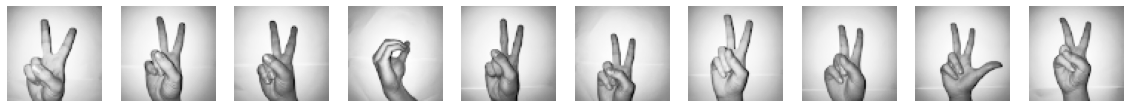

10 Least likely from training set:


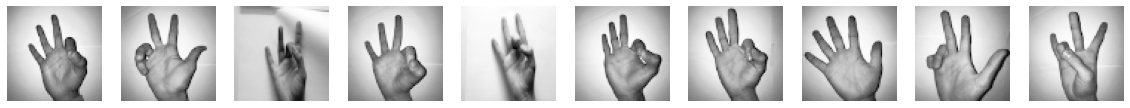

10 Most likely from test set:


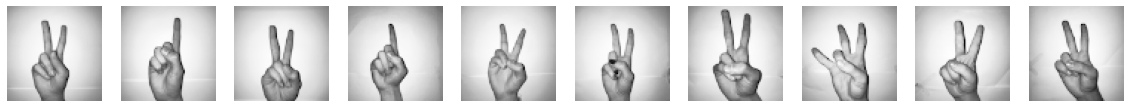

10 Least likely from test set:


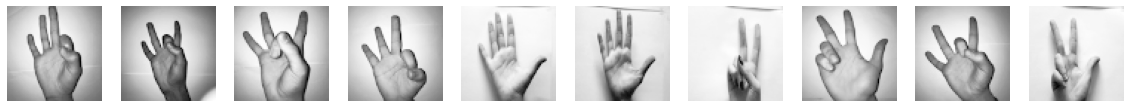

In [ ]:
# View the 10 most and least likely examples to be classified True from both
# the training and the test set.
count = 10

print(f"{count} Most likely from training set:")
show_best(w, b, X_train_flat, X_train, count)
print(f"{count} Least likely from training set:")
show_worst(w, b, X_train_flat, X_train, count)

print(f"{count} Most likely from test set:")
show_best(w, b, X_test_flat, X_test, count)
print(f"{count} Least likely from test set:")
show_worst(w, b, X_test_flat, X_test, count)

# Analysis

Write up your analysis in a new text cell below.  Respond to the following prompts:
1. What learning rate and final cost value did you start with?  What did you end with?  What learning rates did you explore in between?
1. Did you have any learning rates for which the curve oscillated up and down repeatedly?  If so, which were they?  Whether you did or not, what would that indicate about the learning rate and its effect on the training?
1. How do the final results for your digit classification look when you inspect the most- and least-likely 'True' predictions?  Do you see any misclassifications?  What might cause those mispredictions?  What might you be able to do to reduce them?
1. Why do you think we would generally want to split up our examples into separate "training" and "testing" sets?  It has a downside, in that we end up using less data to train the model, so what is the benefit?  Feel free to make an educated guess or look it up to see what you can learn.
1. What was the most challenging part of this assignment for you?



1.   I started with an alpha value of 1, which gave me a disconnected oscillating cost graph as well as a very high cost of ~34. I then dropped down to 0.1, which had another oscillating graph, this time connected. That alpha also had a relatively high cost of ~1.744. I then scaled down another 10, and tried 0.01. The graph looked how it was actually supposed to, and the cost was relatively low at ~0.306. I decided to keep testing, and increment by hundreths. 0.03 ended up being the best sweet spot between lowest cost without having an oscillating graph. 
2.   The oscillating graphs started appearing around the 0.035 mark for alpha. When I was incrementing by 1/100s, 0.04 gave me an oscillating graph, so I decided to go back to 0.3 and increment by 1/1000s to find the limit between a nice cost graph and an oscillating once. 
3.   The model, based on the 20 train/test images for most likely, is relatively accurate. There is a low number of false positives, with 5/20 being misclassified as a 2. Of these 5, 2 are 3's, 2 are 1's, and 1 is a 0. The 1 and 3 errors make a sense, as the model hasn't seen enough data to completely differentiate them from 2's, so some are always going to "slip through the cracks". The three's that failed both had the normal 2 digits up, but instead have an uncoventional third digit up, as a thumb or a pinky. The model must see the two digits, and then the space, and assume it is a 2. A way to improve this model would be to simply feed it more data, or even create a NN with 10 digit nodes to create feature detection, and it will know how to classify ALL of the digits, and not just necessarily the one we're interested in for binary classification/logistic regression. 
4.   The use of training and testing sets is to avoid overfitting by giving the model ALL of the data to train on, so of course it will have a high accuracy with a testing subset fed into it, as it already knows how these are classified. If a new image that the model had never seen before was introduced, the model would struggle to classify it as it has only been trained and refined using the same data, over and over again. 
5.   The most challenging part was definitely testing the functions. In all honesty, I coded all of it to the end without testing just to see what the cost graph would look like at the end. If it looked right, I knew I didn't mess up. But when returning to write the tests, I struggled with conceptually thinking of good edge cases, as well as creating test parameters of the right shape and size. It was also hard to conceptualize what the results should be. I think the most important part of the testing was to make sure the output shapes were correct, so that the next step would not have an error where the dimesnions didn't match correctly. 

